Importar librerías necesarias


In [2]:
# 1. Importar librerías necesarias
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms

Descargar y explorar el dataset CIFAR-100 de Hugging Face

In [3]:
# 2. Descargar y explorar el dataset CIFAR-100 de Hugging Face
dataset = load_dataset("uoft-cs/cifar100")
print(dataset)  # Mostrar las llaves y tamaños de los splits

DatasetDict({
    train: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 10000
    })
})


 Visualizar algunas imágenes de ejemplo

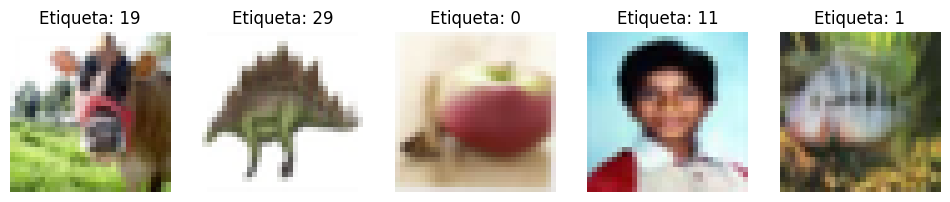

In [4]:
# 3. Visualizar algunas imágenes de ejemplo
fig, axs = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img = dataset["train"][i]["img"]
    label = dataset["train"][i]["fine_label"]
    axs[i].imshow(img)
    axs[i].set_title(f"Etiqueta: {label}")
    axs[i].axis("off")
plt.show()

Preprocesar los datos y crear Dataset personalizado

In [5]:
# 4. Preprocesar los datos y crear Dataset personalizado
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte PIL Image a tensor [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza a [-1,1]
])

class CIFAR100Dataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]["img"]
        label = self.dataset[idx]["fine_label"]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = CIFAR100Dataset(dataset["train"], transform=transform)
test_dataset = CIFAR100Dataset(dataset["test"], transform=transform)

Dividir train en train y validación (80/20)

In [6]:
# 5. Dividir train en train y validación (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
print(f"Tamaño train: {len(train_dataset)}, validación: {len(val_dataset)}, test: {len(test_dataset)}")

Tamaño train: 40000, validación: 10000, test: 10000


Definir el modelo de red neuronal

In [15]:
# 6. Definir un modelo de red convolucional simple para CIFAR-100
class RedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 100)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo = RedCNN().to(device)
print(modelo)

RedCNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=100, bias=True)
  )
)


Preparar DataLoaders

In [16]:
# 7. Preparar DataLoaders
BATCH_SIZE = 42
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

 Definir funciones de entrenamiento y validación

In [17]:
# 8. Definir funciones de entrenamiento y validación
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.001)

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += X.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def val_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            total_loss += loss.item() * X.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += X.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

 Entrenar y validar el modelo

In [18]:
# 9. Entrenar y validar el modelo
EPOCHS = 20
for epoch in range(EPOCHS):
    train_loss, train_acc = train_loop(train_loader, modelo, loss_fn, optimizer)
    val_loss, val_acc = val_loop(val_loader, modelo, loss_fn)
    print(f"Época {epoch+1}/{EPOCHS}")
    print(f"  Entrenamiento -> Pérdida: {train_loss:.4f}, Exactitud: {train_acc*100:.2f}%")
    print(f"  Validación    -> Pérdida: {val_loss:.4f}, Exactitud: {val_acc*100:.2f}%\n")

Época 1/20
  Entrenamiento -> Pérdida: 3.5660, Exactitud: 15.81%
  Validación    -> Pérdida: 3.0413, Exactitud: 25.11%

Época 2/20
  Entrenamiento -> Pérdida: 2.8080, Exactitud: 29.69%
  Validación    -> Pérdida: 2.7480, Exactitud: 30.83%

Época 3/20
  Entrenamiento -> Pérdida: 2.4495, Exactitud: 36.95%
  Validación    -> Pérdida: 2.5877, Exactitud: 34.88%

Época 4/20
  Entrenamiento -> Pérdida: 2.1765, Exactitud: 42.45%
  Validación    -> Pérdida: 2.5341, Exactitud: 36.24%

Época 5/20
  Entrenamiento -> Pérdida: 1.9317, Exactitud: 48.23%
  Validación    -> Pérdida: 2.5268, Exactitud: 37.01%

Época 6/20
  Entrenamiento -> Pérdida: 1.7137, Exactitud: 53.11%
  Validación    -> Pérdida: 2.5632, Exactitud: 36.66%

Época 7/20
  Entrenamiento -> Pérdida: 1.5030, Exactitud: 58.17%
  Validación    -> Pérdida: 2.6432, Exactitud: 36.86%

Época 8/20
  Entrenamiento -> Pérdida: 1.3021, Exactitud: 63.23%
  Validación    -> Pérdida: 2.8226, Exactitud: 36.67%

Época 9/20
  Entrenamiento -> Pérdida: 1

Realizar predicciones con el modelo entrenado y visualizar

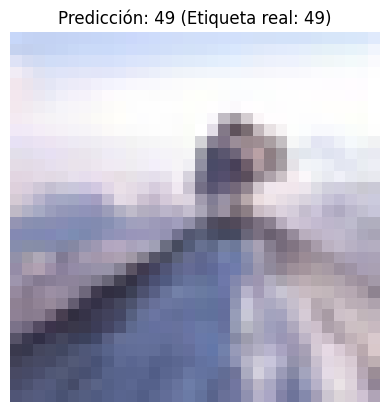

In [19]:
ejemplo_img, ejemplo_lbl = test_dataset[0]
ejemplo_img_gpu = ejemplo_img.unsqueeze(0).to(device)
modelo.eval()
with torch.no_grad():
    logits = modelo(ejemplo_img_gpu)
    pred = logits.argmax(1).item()

plt.imshow(ejemplo_img.permute(1, 2, 0).cpu() * 0.5 + 0.5)  # Desnormalizar para mostrar
plt.title(f"Predicción: {pred} (Etiqueta real: {ejemplo_lbl})")
plt.axis("off")
plt.show()

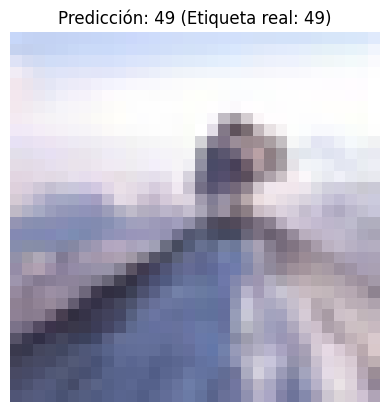

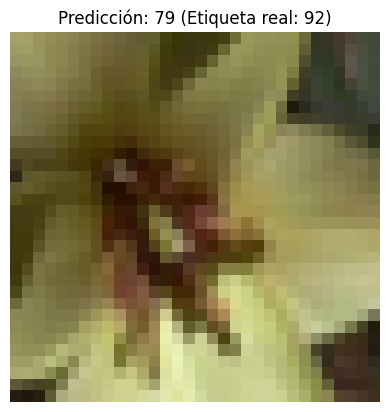

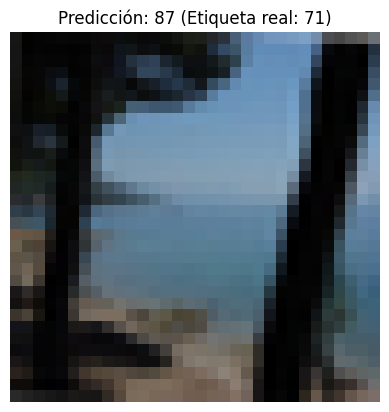

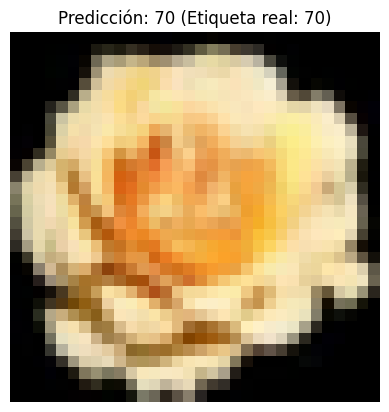

In [21]:
for idx in [0, 5, 10, 20]:
    ejemplo_img, ejemplo_lbl = test_dataset[idx]
    ejemplo_img_gpu = ejemplo_img.unsqueeze(0).to(device)
    modelo.eval()
    with torch.no_grad():
        logits = modelo(ejemplo_img_gpu)
        pred = logits.argmax(1).item()
    plt.imshow(ejemplo_img.permute(1, 2, 0).cpu() * 0.5 + 0.5)
    plt.title(f"Predicción: {pred} (Etiqueta real: {ejemplo_lbl})")
    plt.axis("off")
    plt.show()